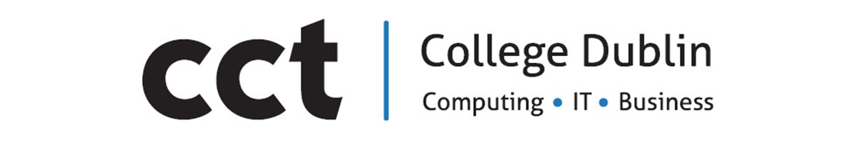

<h1 align="center">Subject: Machine Learning</h1>
<h2 align="center">Lecturer: David McQuaid</h2>
<h3 align="center">Caio Machado de Oliveira</h3>
<h4 align="center">ID: 2020351</h4>
<h5 align="center">April/2024</h5>


In [1]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

%matplotlib inline


# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

rcParams['figure.figsize'] = 15, 6

#ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima import auto_arima

from prophet import Prophet

from pandas import to_datetime




import itertools
import warnings

from datetime import datetime
from datetime import timedelta
from datetime import datetime
warnings.filterwarnings('ignore')



# Data Understanding

In [9]:
data = pd.read_csv("crime-per-county.csv")

data.head()

,STATISTIC Label,Quarter,Garda Division,Type of Offence,UNIT,VALUE
0,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Homicide offences,Number,1.0
1,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Murder,Number,0.0
2,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Manslaughter,Number,0.0
3,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Infanticide,Number,0.0
4,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Dangerous driving leading to death,Number,1.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166992 entries, 0 to 166991
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATISTIC Label  166992 non-null  object 
 1   Quarter          166992 non-null  object 
 2   Garda Division   166992 non-null  object 
 3   Type of Offence  166992 non-null  object 
 4   UNIT             166992 non-null  object 
 5   VALUE            166383 non-null  float64
dtypes: float64(1), object(5)
memory usage: 7.6+ MB


In [8]:
data.describe()

,VALUE
count,166383.000000
mean,58.999219
std,149.652981
min,0.000000
25%,0.000000
50%,4.000000
75%,47.000000
max,2541.000000


In [17]:
data['Quarter'].unique()

array(['2003Q1', '2003Q2', '2003Q3', '2003Q4', '2004Q1', '2004Q2',
       '2004Q3', '2004Q4', '2005Q1', '2005Q2', '2005Q3', '2005Q4',
       '2006Q1', '2006Q2', '2006Q3', '2006Q4', '2007Q1', '2007Q2',
       '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3', '2008Q4',
       '2009Q1', '2009Q2', '2009Q3', '2009Q4', '2010Q1', '2010Q2',
       '2010Q3', '2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4',
       '2012Q1', '2012Q2', '2012Q3', '2012Q4', '2013Q1', '2013Q2',
       '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3', '2014Q4',
       '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
       '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4',
       '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2',
       '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4',
       '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1', '2022Q2',
       '2022Q3', '2022Q4', '2023Q1', '2023Q2', '2023Q3', '2023Q4'],
      dtype=object)

In [18]:
data['Garda Division'].unique()

array(['Cavan/Monaghan Garda Division', 'Donegal Garda Division',
       'Sligo/Leitrim Garda Division', 'Louth Garda Division',
       'Clare Garda Division', 'Mayo Garda Division',
       'Galway Garda Division', 'Roscommon/Longford Garda Division',
       'Cork City Garda Division', 'Cork North Garda Division',
       'Cork West Garda Division', 'Kerry Garda Division',
       'Limerick Garda Division', 'Laois/Offaly Garda Division',
       'Meath Garda Division', 'Wicklow Garda Division',
       'Westmeath Garda Division', 'Kildare Garda Division',
       'Tipperary Garda Division', 'Wexford Garda Division',
       'Kilkenny/Carlow Garda Division', 'Waterford Garda Division',
       'D.M.R. South Central Garda Division',
       'D.M.R. North Central Garda Division',
       'D.M.R. Northern Garda Division', 'D.M.R. Southern Garda Division',
       'D.M.R. Eastern Garda Division', 'D.M.R. Western Garda Division'],
      dtype=object)

In [19]:
data['Type of Offence'].unique()

array(['Homicide offences', 'Murder', 'Manslaughter', 'Infanticide',
       'Dangerous driving leading to death', 'Sexual offences',
       'Rape and sexual assault', 'Other sexual offences',
       'Attempts/threats to murder, assaults, harassments and related offences',
       'Murder-attempt', 'Threat to kill or cause serious harm',
       'Harassment and related offences',
       'Assault causing harm, poisoning', 'Other assault',
       'Dangerous or negligent acts',
       'Dangerous driving causing serious bodily harm',
       'Driving/in charge of a vehicle while over legal alcohol limit',
       'Driving/in charge of a vehicle under the influence of drugs',
       'Endangerment with potential for serious harm/death',
       'Abandoning a child, child neglect and cruelty',
       'Unseaworthy/dangerous use of boat or ship',
       'False alarm/interference with aircraft or air transport facilities',
       'Endangering traffic offences', 'Kidnapping and related offences',
     

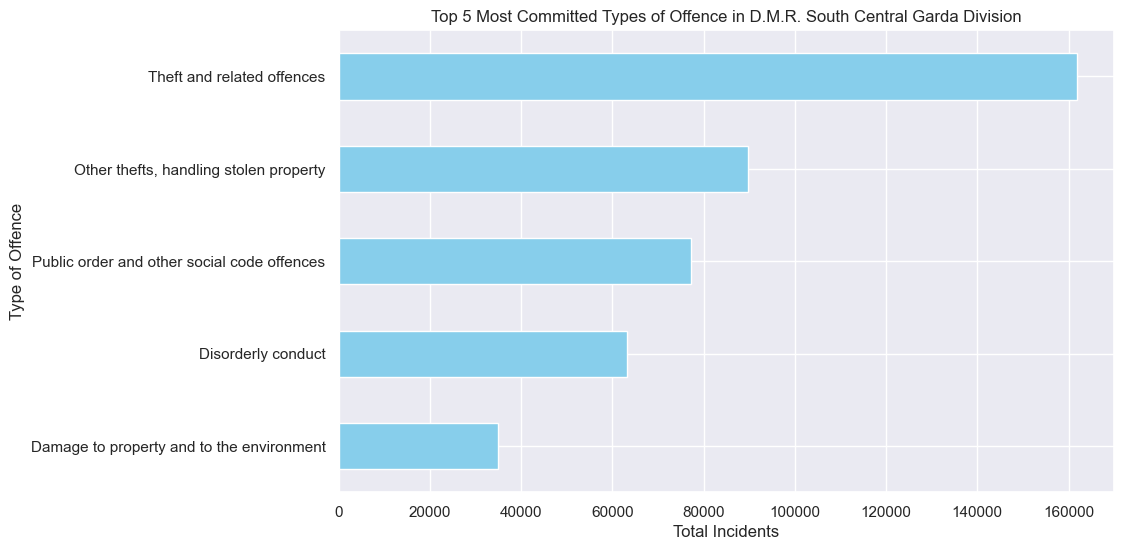

In [22]:
# Filter data for 'D.M.R. South Central Garda Division'
data_south_central = data[data['Garda Division'] == 'D.M.R. South Central Garda Division']

# Group by 'Type of Offence' and sum the 'VALUE' column to get total incidents for each type of offence
data_south_central_5 = data_south_central.groupby('Type of Offence')['VALUE'].sum()

# Sort the totals and get the top 5 most committed types of offences
data_south_central_plot = data_south_central_5.sort_values(ascending=False).head(5)

# Plot the data using horizontal bars
plt.figure(figsize=(10, 6))
data_south_central_plot.plot(kind='barh', color='skyblue')
plt.xlabel('Total Incidents')
plt.title('Top 5 Most Committed Types of Offence in D.M.R. South Central Garda Division')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest value on top
plt.show()

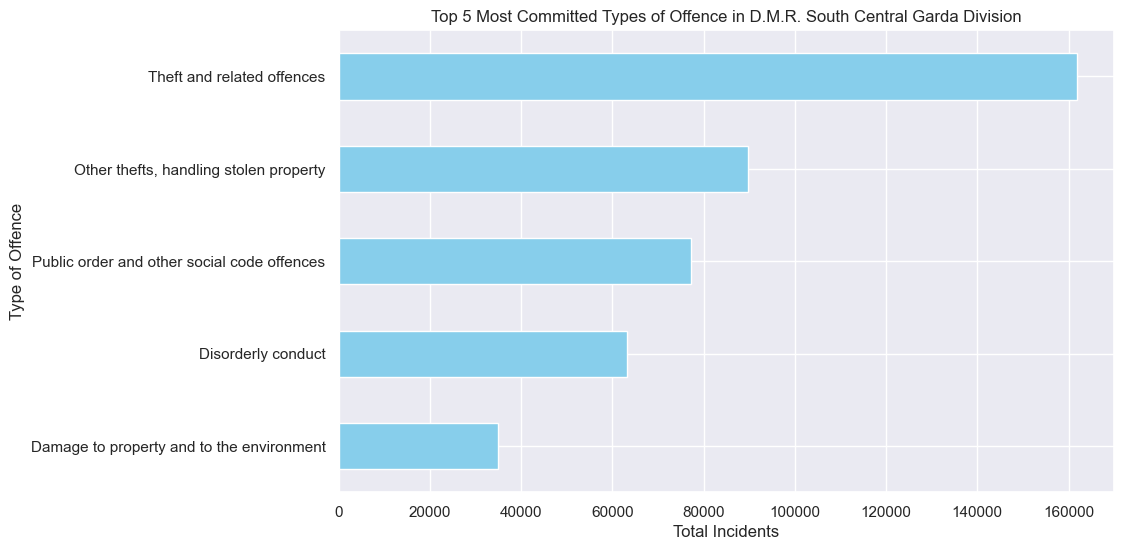

In [24]:
# Filter data for 'D.M.R. South Central Garda Division'
data_north_central = data[data['Garda Division'] == 'D.M.R. South Central Garda Division']

# Group by 'Type of Offence' and sum the 'VALUE' column to get total incidents for each type of offence
data_north_central_5 = data_north_central.groupby('Type of Offence')['VALUE'].sum()

# Sort the totals and get the top 5 most committed types of offences
data_north_central_plot = data_north_central_5.sort_values(ascending=False).head(5)

# Plot the data using horizontal bars
plt.figure(figsize=(10, 6))
data_north_central_plot.plot(kind='barh', color='skyblue')
plt.xlabel('Total Incidents')
plt.title('Top 5 Most Committed Types of Offence in D.M.R. South Central Garda Division')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest value on top
plt.show()

# Data Preparation

In [ ]:
data.drop(columns =["STATISTIC Label", "UNIT"], inplace=True)


In [ ]:
data['VALUE'] = data['VALUE'].fillna(0)


In [ ]:
data['VALUE'] = data['VALUE'].astype('int64')

In [ ]:
data.info()

In [ ]:
def quarter_to_date(year_quarter):
    year, quarter = year_quarter.split('Q')
    first_month = {'1': '01', '2' : '04' , '3' : '07' , '4' : '10'}
    return f"{year}-{first_month[quarter]}-1"

data['Date'] = data['Quarter'].apply(quarter_to_date)



In [ ]:
# Correct way using .loc to avoid SettingWithCopyWarning
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

In [ ]:
data.info()

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [ ]:
data.drop(columns =['Quarter'], inplace=True)

In [ ]:
data.info()

In [ ]:
data = data[data['VALUE'] != 0]

In [ ]:
data.info() 
data.describe()

In [ ]:
data.rename(columns = {'Type of Offence': 'Offence', 'VALUE': 'Crime'}, inplace=True)

In [ ]:
data.head()

In [ ]:
# Filter the data for "Theft from person" crimes in "D.M.R. North Central Garda Division"
theft_from_person_data = data[
    (data['Offence'] == 'Theft from shop') &
    (data['Garda Division'] == 'D.M.R. South Central Garda Division')
]


# Plotting the line graph
plt.figure(figsize=(14, 7))
plt.plot(theft_from_person_data.index, theft_from_person_data['Crime'], marker='o', linestyle='-', color='b')
plt.title('Trend of "Theft from person" in D.M.R. North Central Garda Division')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()


In [ ]:
theft_from_person_data.drop(columns =['Garda Division', 'Offence'], inplace=True)


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(theft_from_person_data, model='additive')

# Plot the decomposed components
decomposition.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(theft_from_person_data['Crime'])

# Display the results of the ADF test
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output['Critical Value (%s)' % key] = value

adf_output

In [ ]:
train = theft_from_person_data['Crime'].loc['2003-01-01': '2022-10-01']
test = theft_from_person_data['Crime'].loc['2023-01-01':]

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(train)

# Display the results of the ADF test
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output['Critical Value (%s)' % key] = value

adf_output

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure for plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot the Autocorrelation Function (ACF)
plot_acf(train, lags=20, ax=ax1)

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(train, lags=20, ax=ax2, method='ywm')

plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(train, model='additive')

# Plot the decomposed components
decomposition.plot()
plt.show()

In [ ]:
import itertools

# Define the d and q parameters to take any value between 0 and 1
d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
q = p = range(0, 5)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
import statsmodels.api as sm

warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [ ]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))
#The smallest AIC is 429.935229273857 for model SARIMAX(3, 1, 1)x(9, 1, 0, 4) 30/04/2024

In [ ]:
import statsmodels.api as sm
import pmdarima as pm

best_model = pm.auto_arima(train,
                           start_p=0, start_q=0,
                           max_p=10, max_q=10,
                           start_P=0, start_Q=0,
                           max_P=10, max_Q=10,
                           m=4,
                           d=None, D=None,
                           max_d=3, max_D=2,
                           seasonal=True,
                           stepwise=False,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           seasonal_test='ocsb',
                           information_criterion='aic',
                           n_jobs=-1)

print(best_model.summary())

In [ ]:
model = SARIMAX(train, order=(3, 1, 1), 
                seasonal_order=(9, 1, 0, 4),
                enforce_stationarity=False,
                enforce_invertibility=False)


model = model.fit()
print(model.summary().tables[1])

In [ ]:
# Get predictions for the test data
forecast = model.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
predictions = forecast.predicted_mean
ci = forecast.conf_int()

# Extract the actual values for the test data
actual = test

# Calculate RMSE
rmse = np.sqrt(((predictions - actual) ** 2).mean())
print('RMSE:', round(rmse, 2))

In [ ]:
# Assuming 'theft_from_person_data', 'ci', and 'predictions' are defined properly
plt.figure(figsize=(14, 7))
plt.plot(theft_from_person_data['Crime'].index, theft_from_person_data['Crime'], label='Observed', color='blue', alpha=0.75)
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')
plt.plot(predictions.index, predictions, label='Predictions', color='red', alpha=0.7)

# Highlight the prediction period
plt.axvline(x=test.index[0], color='green', linestyle=':', linewidth=2, label='Start of Predictions')

plt.xlabel('Date')
plt.ylabel('Crime')
plt.title('Observed Crime vs. Predictions')
plt.legend(loc='upper left')
plt.grid(True)  # Adding a grid for better readability
plt.show()

In [ ]:
from sklearn.metrics import r2_score
# Calculate the R² score
r2 = r2_score(test, predictions)

# Print the R² score
print(f'R² score: {r2}')

In [ ]:
train_end = pd.Timestamp('2021-12-31')
rolling_predictions = test.copy()
for train_end in test.index:
    train = theft_from_person_data['Crime'][:train_end - pd.DateOffset(months=3)]
    model = SARIMAX(train,order=(0,1,3),seasonal_order=(0,0,0,4)) 

    model_fit = model.fit()
    
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [ ]:
rolling_residuals = test - rolling_predictions

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [ ]:
# Begin visualization improvements
plt.figure(figsize=(14, 7))

# Plot the actual data
plt.plot(theft_from_person_data['Crime'].index, theft_from_person_data['Crime'], label='Observed Data', color='blue', alpha=0.75)
# Plot rolling predictions
plt.plot(rolling_predictions.index, rolling_predictions, label='Rolling Predictions', color='red', alpha=0.7)


# Adding enhancements
plt.title('Observed Crime Data vs. Rolling Predictions')  # Title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Crime Rate')  # Y-axis label
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Ensure legend is correctly placed

# Highlight the prediction period
plt.axvline(x=test.index[0], color='green', linestyle=':', linewidth=2, label='Start of Predictions')

plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, rolling_predictions)
rmse = np.sqrt(mean_squared_error(test, rolling_predictions))

print("MAE:", mae)
print("RMSE:", rmse)


In [ ]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# Calculate the R² score
r2 = r2_score(test, rolling_predictions)

# Print the R² score
print(f'R² score: {r2}')


In [ ]:
# Forecast the next 4 quarters
forecasted_rolling = model_fit.forecast(steps=4)
forecasted_values = model.forecast(steps=4)

# Print the forecasted values
print("Forecasted values for the next 4 quarters:", forecasted_rolling)
print("Forecasted values for the next 4 quarters:", forecasted_values)




In [ ]:
# Example figsize set for better display
plt.figure(figsize=(14, 7))

# Plotting each time series with specific color and style
plt.plot(train.index, train, color='blue', label='Train Data', alpha=0.7)
plt.plot(predictions.index, predictions, color='green', label='Predictions', alpha=0.7)
plt.plot(rolling_predictions.index, rolling_predictions, color='red', label='Rolling Predictions', alpha=0.7)
plt.plot(forecasted_rolling.index, forecasted_rolling, color='purple', label='Forecasted Values', alpha=0.7)
plt.plot(forecasted_values.index, forecasted_values, color='orange', label='Forecasted Original', alpha=0.7)

# Enhancements for readability
plt.title('Comparison of Train, Predictions, and Forecasts')  # Adding a title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Values')  # Y-axis label
plt.grid(True)  # Enable grid for easier reading
plt.legend(loc='best')  # Relocate legend to the best location

# Show the plot
plt.show()
